# Unsupervised Classification of Machine Learning Paper Abstracts
Every year, tens of thousands of papers on machine learning are published. This makes the academic literature about machine learning itself a source of big data - with all of the problems that this brings. Given the plethora of papers, it is useful to have tools to help a researcher identify which papers might be useful to read and which are not. 

Two features of papers which are commonly used to classify papers are abstracts and keywords, but both have their limitations. While academic papers usually have abstracts that summarize the paper, reading hundreds or thousands of abstracts is also often not an efficient use of time. Keywords can more efficiently classify papers, but relying on them suffers from at least two problems: first many papers and journals do not include keywords, and second, the author's or editor's choice of keywords may be inaccurate or overly general (e.g. "machine learning"). 

Using unsupervised learning to help classify papers, then, may help researchers and scientists to better sift through the big data of academic articles to more efficiently target their efforts and time.

In this notebook I use two different unsupervised techniques (BERTopic and Non-Negative Matrix Factorization) to classifying the abstracts of academic papers on machine learning (ML) and artificial intelligence (AI). The data consists of nearly 36,000 academic papers scraped from the arXiv dataset (https://www.kaggle.com/datasets/Cornell-University/arxiv?select=arxiv-metadata-oai-snapshot.json).

The repository for this nnotebook can be found at https://github.com/jeffhaines20/Abstract-Classification. 


## Installing the libraries and loading the data

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
try: 
  from bertopic import BERTopic
except ModuleNotFoundError:
  !pip install bertopic
  from bertopic import BERTopic

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I had saved the scraped journal articles and their abstracts in 10 JSON files. There are approximately 100,000 articles in the dataset which were categorized as ML or AI. Because of the time involved and in scraping so many articles, I limited myself to using about half of the articles. Of those roughly 50,000 articles, around 14,000 had the text and headers arranged in a way that my scraping script had difficulty distinguishing between the text and the abstract. This left 36,195 articles. 

As I later discovered, however, some of these articles were implausibly short, with the shortest being only four words (!). As such short articles likely either reflect errors in the scraping or short pieces like tables of contents or letters to the editor, I set the threshold for the minimum article size at 1,000 words. 

Here I load the JSON files into a single dictionary for ease of use and count how many are above my threshold of 1,000 words. We can see that there are 35,769 ML and AI articles. This should still be more than enough to build a good abstract-classifier.

In [3]:
article_count = 0
text_word_counts = []
abstract_word_counts = []

article_dict = {'abstract':[],'text':[]}
nums = np.arange(5,55,5)

for num in nums:
  string_num = str(num)
  if len(string_num) == 1:
    string_num = '0' + string_num
  #df = pd.read_json(f'/content/drive/MyDrive/ML Papers/ml_articles_{string_num}_pct.json', orient = 'index')
  with open(f'/content/drive/MyDrive/ML Papers/ml_articles_{string_num}_pct.json') as f:
    data = json.load(f)

    for key in data.keys():
      text_word_count = len(data[key]['text'].split())

      if text_word_count >= 1000:
        article_dict['abstract'].append([data[key]['abstract']])
        article_dict['text'].append([data[key]['text']])

        article_count += 1
        text_word_counts.append(text_word_count)
        abstract_word_count = len(data[key]['abstract'].split())
        abstract_word_counts.append(abstract_word_count)

  print(article_count)

3624
7188
10814
14381
17879
21661
24849
28359
32197
35769


As most of the articles are rather long, I print out a small part of one sample article and the article's abstract.

In [4]:
article_dict['text'][0][0][:1000]

'\nAcoustic emission (AE) concerns non-destructive testing\nmethods and is used to locate and characterize developing\ncracks and defects in material. In non-destructive testing of\naviation frame structures, acoustic emission is a well acce pted\nmethod [8]. The location problem is usually solved by variou s\ntriangulationtechniquesbasedonthe analysisof ultrason icray\ntrajectories[10], [1], [3]. Solvingandprogrammingthe re lated\nequation is rather cumbersome and cannot be simply per-\nformed if the structure of the tested specimen is geometrica lly\ncomplicated. Acoustic emission testing of aircraft struct ures\nis a challenging and difﬁcult problem. The structures invol ve\nbolts, fasteners and plates, all of which move relative to on e\nanother due to differential structural loading during ﬂigh t. The\ncomplex geometry of the airframe results in multiple mode\nconversions of AE source signals, compounding the difﬁcult y\nof relating the source event to the detected signal.\nIn ord

In [7]:
article_dict['abstract'][0]

['  The intelligent acoustic emission locator is described in Part I, while Part\nII discusses blind source separation, time delay estimation and location of two\nsimultaneously active continuous acoustic emission sources.\n  The location of acoustic emission on complicated aircraft frame structures is\na difficult problem of non-destructive testing. This article describes an\nintelligent acoustic emission source locator. The intelligent locator comprises\na sensor antenna and a general regression neural network, which solves the\nlocation problem based on learning from examples. Locator performance was\ntested on different test specimens. Tests have shown that the accuracy of\nlocation depends on sound velocity and attenuation in the specimen, the\ndimensions of the tested area, and the properties of stored data. The location\naccuracy achieved by the intelligent locator is comparable to that obtained by\nthe conventional triangulation method, while the applicability of the\nintellige

## EDA
Let's explore some of the features of the data set. Unfortunately the arXiv metadata did not include the year of each paper's publication. This information was sometimes included in the "journal-ref" field, but many papers lacked this field and the formatting of the dates varied quite a bit. Thus I do not break down the information below by year.

We can see that the averge article was 7,221 words, with a fairly large standard deviation. We can see that, with this threshold, the shortest article is 1,007 words, and the longest is nearly 200,000 words.

In [8]:
print('Articles:')
print(' Average word count: ',np.mean(text_word_counts))
print(' Standard deviation: ',np.std(text_word_counts))
print(' Maximum word count: ' ,max(text_word_counts))
print(' Minimum word count: ' ,min(text_word_counts))

Articles:
 Average word count:  7221.178254913472
 Standard deviation:  5002.926807070514
 Maximum word count:  196652
 Minimum word count:  1007


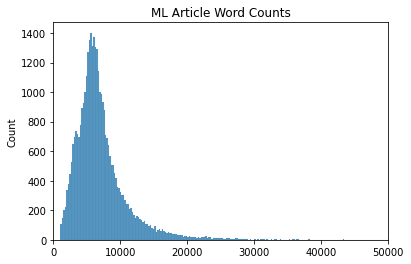

In [9]:
# plot a historgram
sns.histplot(text_word_counts)
plt.xlim(0, 50_000)
plt.title('ML Article Word Counts')
plt.show()

We can also examine the length of abstracts. The average abstract had a length of 153.1 words.

In [10]:
print('Abstracts:')
print(' Average word count: ',np.mean(abstract_word_counts))
print(' Standard deviation: ',np.std(abstract_word_counts))
print(' Maximum word count: ' ,max(abstract_word_counts))
print(' Minimum word count: ' ,min(abstract_word_counts))

Abstracts:
 Average word count:  153.0813833207526
 Standard deviation:  50.65202807974278
 Maximum word count:  584
 Minimum word count:  5


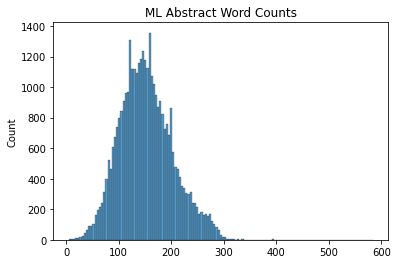

In [11]:
sns.histplot(abstract_word_counts)
plt.title('ML Abstract Word Counts')
plt.show()

I load the data into a dataframe to make it easier to work with.

In [5]:
abstract = pd.Series(a[0] for a in article_dict['abstract'])
text = pd.Series(t[0] for t in article_dict['text'])

df = pd.DataFrame({'abstract':abstract,'text':text})
df.head()

,abstract,text
0,The intelligent acoustic emission locator is...,\nAcoustic emission (AE) concerns non-destruct...
1,Part I describes an intelligent acoustic emi...,\nA common goal of many non-destructivetesting...
2,This paper discusses the benefits of describ...,\nThroughout history we have used concepts fro...
3,Ordinal regression is an important type of l...,\nOrdinal regression (or ranking learning) is ...
4,This paper explores the following question: ...,\nSeveral methods have been developed lately f...


Check to make sure we have the right number of rows.

In [68]:
len(df)

35769

Next I make a CountVectorizer object to help count the number of documents each word occurred in. I omit common stopwords.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
vectorizer_model = CountVectorizer(stop_words="english")

In [12]:
count_vec = vectorizer_model.fit(df['abstract'])
bag_of_words = count_vec.transform(df['abstract'])

#Get the frequency of each word.
total = bag_of_words.sum(axis=0) 
total

matrix([[  8, 308,   1, ...,   1,   1,   1]])

In [21]:
total.shape

(1, 51888)

There are 51,888 unique non-stopwords in my dataset. We can see that the most common single words are, unsurprisingly, "learning", "data", and "model".

In [22]:
frequencies = [(word, total[0, i]) for word, i in count_vec.vocabulary_.items()]
frequencies =sorted(frequencies, key = lambda x: x[1], reverse=True)
print(frequencies[:20])

[('learning', 32415), ('data', 30987), ('model', 27011), ('based', 20838), ('models', 18566), ('algorithm', 16299), ('problem', 16277), ('paper', 16162), ('method', 15432), ('methods', 15036), ('using', 14310), ('approach', 13989), ('results', 13557), ('propose', 12914), ('network', 12749), ('networks', 12160), ('neural', 12007), ('performance', 11931), ('proposed', 11741), ('new', 11416)]


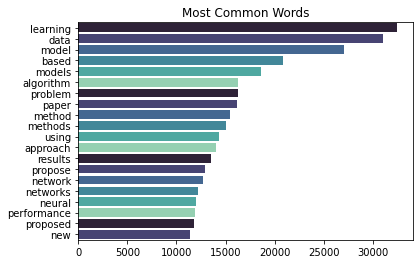

In [24]:
x,y=map(list,zip(*frequencies[0:20]))

p = sns.color_palette("mako")
sns.barplot(x=y,y=x, palette = p).set_title('Most Common Words')
plt.show()

I also check the bi- and tri-grams which occur in the most documents. Again, no surprises. The most common bi-gram (with stop words removed) is "state art".

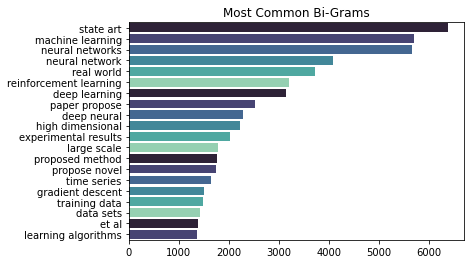

In [27]:
two_count_vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(df['abstract'])
bag_of_words = two_count_vec.transform(df['abstract'])
total = bag_of_words.sum(axis=0) 
frequencies = [(word, total[0, i]) for word, i in two_count_vec.vocabulary_.items()]
frequencies =sorted(frequencies, key = lambda x: x[1], reverse=True)
x,y=map(list,zip(*frequencies[0:20]))

p = sns.color_palette("mako")
sns.barplot(x=y,y=x, palette = p).set_title('Most Common Bi-Grams');

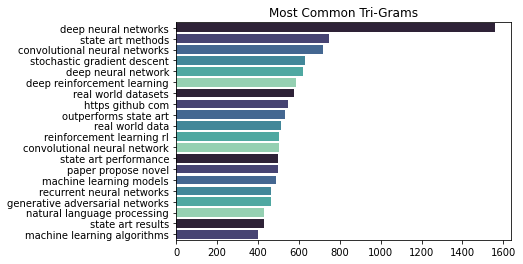

In [29]:
three_count_vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(df['abstract'])
bag_of_words = three_count_vec.transform(df['abstract'])
total = bag_of_words.sum(axis=0) 
frequencies = [(word, total[0, i]) for word, i in three_count_vec.vocabulary_.items()]
frequencies =sorted(frequencies, key = lambda x: x[1], reverse=True)
x,y=map(list,zip(*frequencies[0:20]))

p = sns.color_palette("mako")
sns.barplot(x=y,y=x, palette = p).set_title('Most Common Tri-Grams');

## Unsupervised Learning with BERTopic
With the exploratory data analysis finished, I turn to my first unsupervise model. For the first pass at modeling the abstract topics, I will use BERTopic, which uses a transformer model to create topic clusters (https://maartengr.github.io/BERTopic/index.html#installation).

I create the BERTopic model using the previous count vectorizer and then fit the model to the abstracts.

In [10]:
topic_model = BERTopic(vectorizer_model=vectorizer_model, language="english", calculate_probabilities=True, verbose=True, min_topic_size = 100)
topics, probs = topic_model.fit_transform(df['abstract'])

Batches:   0%|          | 0/1118 [00:00<?, ?it/s]

2023-03-04 05:22:10,974 - BERTopic - Transformed documents to Embeddings
2023-03-04 05:22:54,183 - BERTopic - Reduced dimensionality
2023-03-04 05:23:05,290 - BERTopic - Clustered reduced embeddings


In [11]:
freq = topic_model.get_topic_info()

The BERTopic model found 63 topics that had at least 100 articles. The topics are ordered below (note that the topic -1 is a miscellaneous category that has articles which did not fit into any of the other topics).

In [23]:
freq

,Topic,Count,Name
0,-1,14485,-1_data_learning_model_models
1,0,1574,0_policy_reinforcement_learning_rl
2,1,1031,1_variational_inference_gaussian_posterior
3,2,863,2_recommendation_items_users_user
4,3,860,3_regret_bandit_online_bandits
...,...,...,...
58,57,117,57_equations_pdes_differential_physical
59,58,113,58_multiagent_agents_communication_marl
60,59,112,59_sparse_recovery_sensing_signal
61,60,101,60_traffic_driving_autonomous_vehicle


The three most popular topics are listed below.

In [19]:
topic_model.get_topic(0)

[('policy', 0.03541362004513966),
 ('reinforcement', 0.03241824419041572),
 ('learning', 0.024440416967946715),
 ('rl', 0.02321680095026053),
 ('reward', 0.016629999604955835),
 ('policies', 0.016215805988655286),
 ('agent', 0.016182411193660585),
 ('exploration', 0.01503865145615558),
 ('environment', 0.015013483726402635),
 ('tasks', 0.014591018296445584)]

In [20]:
topic_model.get_topic(1)

[('variational', 0.026126416839527242),
 ('inference', 0.025752850172833987),
 ('gaussian', 0.024074846989291885),
 ('posterior', 0.02259934988742138),
 ('carlo', 0.018401411850458307),
 ('monte', 0.018175085630592697),
 ('bayesian', 0.018135221105044366),
 ('gp', 0.016845567078695133),
 ('mcmc', 0.016238734691561715),
 ('process', 0.015425730530817267)]

In [21]:
topic_model.get_topic(2)

[('recommendation', 0.027896531123192375),
 ('items', 0.027500635775103505),
 ('users', 0.02612378769186731),
 ('user', 0.024890261279750334),
 ('ranking', 0.022961644194318495),
 ('recommender', 0.01968453837041299),
 ('item', 0.017848720597747978),
 ('collaborative', 0.014233123047765727),
 ('model', 0.013014731524308144),
 ('recommendations', 0.012660863698804922)]

Because Github has difficulty displaying interactive plots, I will save the plots as images. Below we can see how various words were associated with the different topics.

In [16]:
fig1 = topic_model.visualize_barchart(width=325)
fig1.show()

BERTopic allows for conveniently visualizing topic clustering. 

In [17]:
fig2 = topic_model.visualize_topics()
fig2.show()

This results in 10 distinct topic clusters ion the intertopic distance map. Hovering over the topics and inspecting the keywords, the clusters seem to often correspond with specific areas in artificial intelligence. The cluster in the upper left, for example, seems clearly related to question answering, graphs, and semantics. Some of the results are less intuitive - topics 0 and 3, which both seem to be about reinforcement learning, are farther from each other in the intertopic space than might be expected.

We can also visualize the topics hierarchically, as below.

In [18]:
fig3 = topic_model.visualize_hierarchy()
fig3.show()

We can inspect which topic each abstract was assigned to and the confidence that the model had that in this assignment.

In [24]:
topic_model.get_document_info(df['abstract'])[:10]

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,The intelligent acoustic emission locator is...,-1,-1_data_learning_model_models,data - learning - model - models - paper - pro...,0.649432,False
1,Part I describes an intelligent acoustic emi...,-1,-1_data_learning_model_models,data - learning - model - models - paper - pro...,0.619310,False
2,This paper discusses the benefits of describ...,14,14_ai_intelligence_artificial_human,ai - intelligence - artificial - human - syste...,0.322313,False
3,Ordinal regression is an important type of l...,2,2_recommendation_items_users_user,recommendation - items - users - user - rankin...,0.234133,False
4,This paper explores the following question: ...,25,25_lasso_regression_selection_sparse,lasso - regression - selection - sparse - grou...,0.289807,False
5,In these notes we formally describe the func...,-1,-1_data_learning_model_models,data - learning - model - models - paper - pro...,0.287614,False
6,This paper has been withdrawn by the author....,-1,-1_data_learning_model_models,data - learning - model - models - paper - pro...,0.274943,False
7,"Information integration applications, such a...",-1,-1_data_learning_model_models,data - learning - model - models - paper - pro...,0.056902,False
8,The social media site Flickr allows users to...,-1,-1_data_learning_model_models,data - learning - model - models - paper - pro...,0.082500,False
9,We present a formal model to represent and s...,5,5_planning_search_problem_heuristic,planning - search - problem - heuristic - plan...,0.349476,False


I save the topic and probability columns to the data frame so I can compare the performance of BERTopic with NMF later.

In [25]:
bertopics = topic_model.get_document_info(df['abstract'])['Topic']
bert_probs = topic_model.get_document_info(df['abstract'])['Probability']
df['bertopic'] = bertopics
df['bert_probs'] = bert_probs

In [26]:
df.head(10)

,abstract,text,bertopic,bert_probs
0,The intelligent acoustic emission locator is...,\nAcoustic emission (AE) concerns non-destruct...,-1,0.649432
1,Part I describes an intelligent acoustic emi...,\nA common goal of many non-destructivetesting...,-1,0.619310
2,This paper discusses the benefits of describ...,\nThroughout history we have used concepts fro...,14,0.322313
3,Ordinal regression is an important type of l...,\nOrdinal regression (or ranking learning) is ...,2,0.234133
4,This paper explores the following question: ...,\nSeveral methods have been developed lately f...,25,0.289807
5,In these notes we formally describe the func...,\nInteractive conﬁguration problems are specia...,-1,0.287614
6,This paper has been withdrawn by the author....,\nRecently the data eciency and complexity of...,-1,0.274943
7,"Information integration applications, such a...","\nAs the Web matures, an increasing number of ...",-1,0.056902
8,The social media site Flickr allows users to...,\nThe photosharingsite Flickr is one of the ea...,-1,0.082500
9,We present a formal model to represent and s...,"\nTowards the second half of the nineties, Int...",5,0.349476


Since the data is unlabeled, it is difficult to tell if these assignments are appropriate or not. The only way to really make this judgment is to manually read the abstracts and see if they seem to fit the topic. Below I print the five abstracts that the model was most confident belonged in topics 0 or 1.

Topic 0 seems to be about reinforcement learning.

In [27]:
[a for a in df[df['bertopic']==0].sort_values('bert_probs', ascending = False)[:5]['abstract']]

['  The concept of the value-gradient is introduced and developed in the context\nof reinforcement learning. It is shown that by learning the value-gradients\nexploration or stochastic behaviour is no longer needed to find locally optimal\ntrajectories. This is the main motivation for using value-gradients, and it is\nargued that learning value-gradients is the actual objective of any\nvalue-function learning algorithm for control problems. It is also argued that\nlearning value-gradients is significantly more efficient than learning just the\nvalues, and this argument is supported in experiments by efficiency gains of\nseveral orders of magnitude, in several problem domains. Once value-gradients\nare introduced into learning, several analyses become possible. For example, a\nsurprising equivalence between a value-gradient learning algorithm and a\npolicy-gradient learning algorithm is proven, and this provides a robust\nconvergence proof for control problems using a value function wit

Judging from the words associated with topic 1, it seems like it should contain abstracts having to do with statistical methods or probability. At least four of the five abstracts below do seem to be appropriately categorized.

In [28]:
[a for a in df[df['bertopic']==1].sort_values('bert_probs', ascending = False)[:5]['abstract']]

['  Performing exact Bayesian inference for complex models is computationally\nintractable. Markov chain Monte Carlo (MCMC) algorithms can provide reliable\napproximations of the posterior distribution but are expensive for large\ndatasets and high-dimensional models. A standard approach to mitigate this\ncomplexity consists in using subsampling techniques or distributing the data\nacross a cluster. However, these approaches are typically unreliable in\nhigh-dimensional scenarios. We focus here on a recent alternative class of MCMC\nschemes exploiting a splitting strategy akin to the one used by the celebrated\nalternating direction of multipliers (ADMM) optimization algorithm. These\nmethods appear to provide empirically state-of-the-art performance but their\ntheoretical behavior in high dimension is currently unknown. In this paper, we\npropose a detailed theoretical study of one of these algorithms known as the\nsplit Gibbs sampler. Under regularity conditions, we establish explici

## Non-Negative Matrix Factorization
The second unsupervised method that I will use is non-negative matrix factorization (NMF). NMF works by decomposing 

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

First I create a TFIDF (term frequency - inverse document frequency) vectorizer to store the TFIDF scores for the 5,000 most common words in the 35,769 documents.

In [30]:
# create a TF-IDF vectorizer object
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,3))

In [31]:
# fit it to the training text
tfidf = tfidf_vectorizer.fit_transform(df['abstract'])

In [32]:
print("Shape of A matrix is: ",tfidf.A.shape)
tfidf.A

Shape of A matrix is:  (35769, 5000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Next I use NMF to fit the TFIDF vectorizer. Since i have no *a priori* expectations about the number of categories, I set the number of components to be 63, to match the results of BERTopic.

In [33]:
nmf = NMF(n_components = 63, random_state=1, beta_loss="kullback-leibler", solver="mu", max_iter=1000, alpha_W=0.1, alpha_H = 0.1).fit(tfidf)

The W matrix shows how well each document fits with each topic, while the H matrix shows how each word fits with each topic. After calculating the matrices, I create a data frame and assign each document to the topic for which it has the highest score (`yhat` in the table below).

In [34]:
W = nmf.fit_transform(tfidf)
print("Shape of W matrix is: ",W.shape)

Shape of W matrix is:  (35769, 63)


In [35]:
H = nmf.components_
print("Shape of H matrix is: ",H.shape)

Shape of H matrix is:  (63, 5000)


In [36]:
preds = pd.DataFrame(np.round(W,3))
preds['max'] = preds.max(axis=1)
preds['yhat'] = np.argmax(preds.values, axis = 1)
preds[:20]

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,max,yhat
0,0.009,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000,...,0.000,0.000,0.000,0.010,0.000,0.000,0.000,0.003,0.041,42
1,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.005,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.040,42
2,0.008,0.000,0.000,0.000,0.007,0.000,0.000,0.000,0.000,0.000,...,0.000,0.036,0.000,0.010,0.000,0.000,0.000,0.000,0.036,56
3,0.024,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.000,0.002,...,0.009,0.000,0.000,0.010,0.000,0.002,0.000,0.000,0.046,28
4,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.056,14
5,0.000,0.000,0.000,0.000,0.028,0.000,0.000,0.000,0.007,0.000,...,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.020,0.038,24
6,0.013,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.013,0.012,...,0.028,0.000,0.000,0.000,0.000,0.000,0.000,0.021,0.028,41
7,0.007,0.000,0.000,0.000,0.000,0.013,0.006,0.000,0.000,0.010,...,0.053,0.000,0.000,0.025,0.000,0.000,0.000,0.005,0.053,55
8,0.014,0.000,0.003,0.000,0.005,0.010,0.000,0.000,0.000,0.000,...,0.048,0.010,0.011,0.000,0.000,0.000,0.012,0.000,0.048,55
9,0.005,0.000,0.000,0.007,0.028,0.000,0.028,0.000,0.000,0.013,...,0.000,0.000,0.000,0.026,0.028,0.011,0.000,0.010,0.036,19


In [37]:
df['nmf'] = preds['yhat']
df['nmf_score'] = preds['max']

I add the results from the NMF to the data frame. Now for each document, we can see both how BERTopic and NMF classify the document. I also include the probability or score for the highest rated category for each document. This gives us some measure of how confident the models are in topic assignment.

In [38]:
df.head()

,abstract,text,bertopic,bert_probs,nmf,nmf_score
0,The intelligent acoustic emission locator is...,\nAcoustic emission (AE) concerns non-destruct...,-1,0.649432,42,0.041
1,Part I describes an intelligent acoustic emi...,\nA common goal of many non-destructivetesting...,-1,0.619310,42,0.040
2,This paper discusses the benefits of describ...,\nThroughout history we have used concepts fro...,14,0.322313,56,0.036
3,Ordinal regression is an important type of l...,\nOrdinal regression (or ranking learning) is ...,2,0.234133,28,0.046
4,This paper explores the following question: ...,\nSeveral methods have been developed lately f...,25,0.289807,14,0.056


Let's look at some of the abstracts that the NMF model was most confident about. I will start with category 1, which has 1,563 documents.

In [39]:
len(df[df['nmf']==1])

1563

The abstracts for topic 1 seem to be largely about optimization methods.

In [40]:
[a for a in df[df['nmf']==1].sort_values('nmf_score', ascending = False)[:5]['abstract']]

['  Here we study non-convex composite optimization: first, a finite-sum of\nsmooth but non-convex functions, and second, a general function that admits a\nsimple proximal mapping. Most research on stochastic methods for composite\noptimization assumes convexity or strong convexity of each function. In this\npaper, we extend this problem into the non-convex setting using variance\nreduction techniques, such as prox-SVRG and prox-SAGA. We prove that, with a\nconstant step size, both prox-SVRG and prox-SAGA are suitable for non-convex\ncomposite optimization, and help the problem converge to a stationary point\nwithin $O(1/\\epsilon)$ iterations. That is similar to the convergence rate seen\nwith the state-of-the-art RSAG method and faster than stochastic gradient\ndescent. Our analysis is also extended into the min-batch setting, which\nlinearly accelerates the convergence. To the best of our knowledge, this is the\nfirst analysis of convergence rate of variance-reduced proximal stochas

Looking at the abstract that were most confidently placed in topic 2, it is apprent that this topic reinforcement learning and Deep Q-Networks.

In [41]:
[a for a in df[df['nmf']==2].sort_values('nmf_score', ascending = False)[:5]['abstract']]

["  Learning goal-directed behavior in environments with sparse feedback is a\nmajor challenge for reinforcement learning algorithms. The primary difficulty\narises due to insufficient exploration, resulting in an agent being unable to\nlearn robust value functions. Intrinsically motivated agents can explore new\nbehavior for its own sake rather than to directly solve problems. Such\nintrinsic behaviors could eventually help the agent solve tasks posed by the\nenvironment. We present hierarchical-DQN (h-DQN), a framework to integrate\nhierarchical value functions, operating at different temporal scales, with\nintrinsically motivated deep reinforcement learning. A top-level value function\nlearns a policy over intrinsic goals, and a lower-level function learns a\npolicy over atomic actions to satisfy the given goals. h-DQN allows for\nflexible goal specifications, such as functions over entities and relations.\nThis provides an efficient space for exploration in complicated environments

In [42]:
from sklearn.metrics import confusion_matrix

Since the abstracts are not labeled with any ground truth categories, it is difficult to determine how well the two models did. We can, however compare the performance of the two against each other. Since both models have the same number of categories, we should expect that each category for one model should be highly correlated with a category from the other model. On the other hand, if there is not much correlation between the categories of the two models, then the two models are identifying very different features of the documents, and we should have less confidence in the results of either or both models.

To try to tell if the models are ientifying the same categories, I use a heatmap, below. With 60 categories for each model, the visualization is not ideal, but it does give us some sense of how well the two models align. 

We can see that the first BERTopic category, the miscellaneuous category (which was topic -1 but is labeled here as 0) contains many of the topics that NMF identified. This is not unexpected, however, as NMF did not inclue a miscellaneous category. Aside from the miscellaneous category, the other BERTopics, especially the topics with a greater number of documents in them, do tend to correlate with single cateogires identified by the NMF model. BERTopic 1, for example, is very strongly associated with NMF category 3, BERTopic 2 is highly correlated with NMF category 6, and so on. 

In a few cases, the topics from one model are associated with more than one category from the other. BERTopic 11, for example, seems to be associated with NMF categories 4 and 22. Nonetheless, most topics from one model are associated only with one category form the other, increasing confidence in the results. 

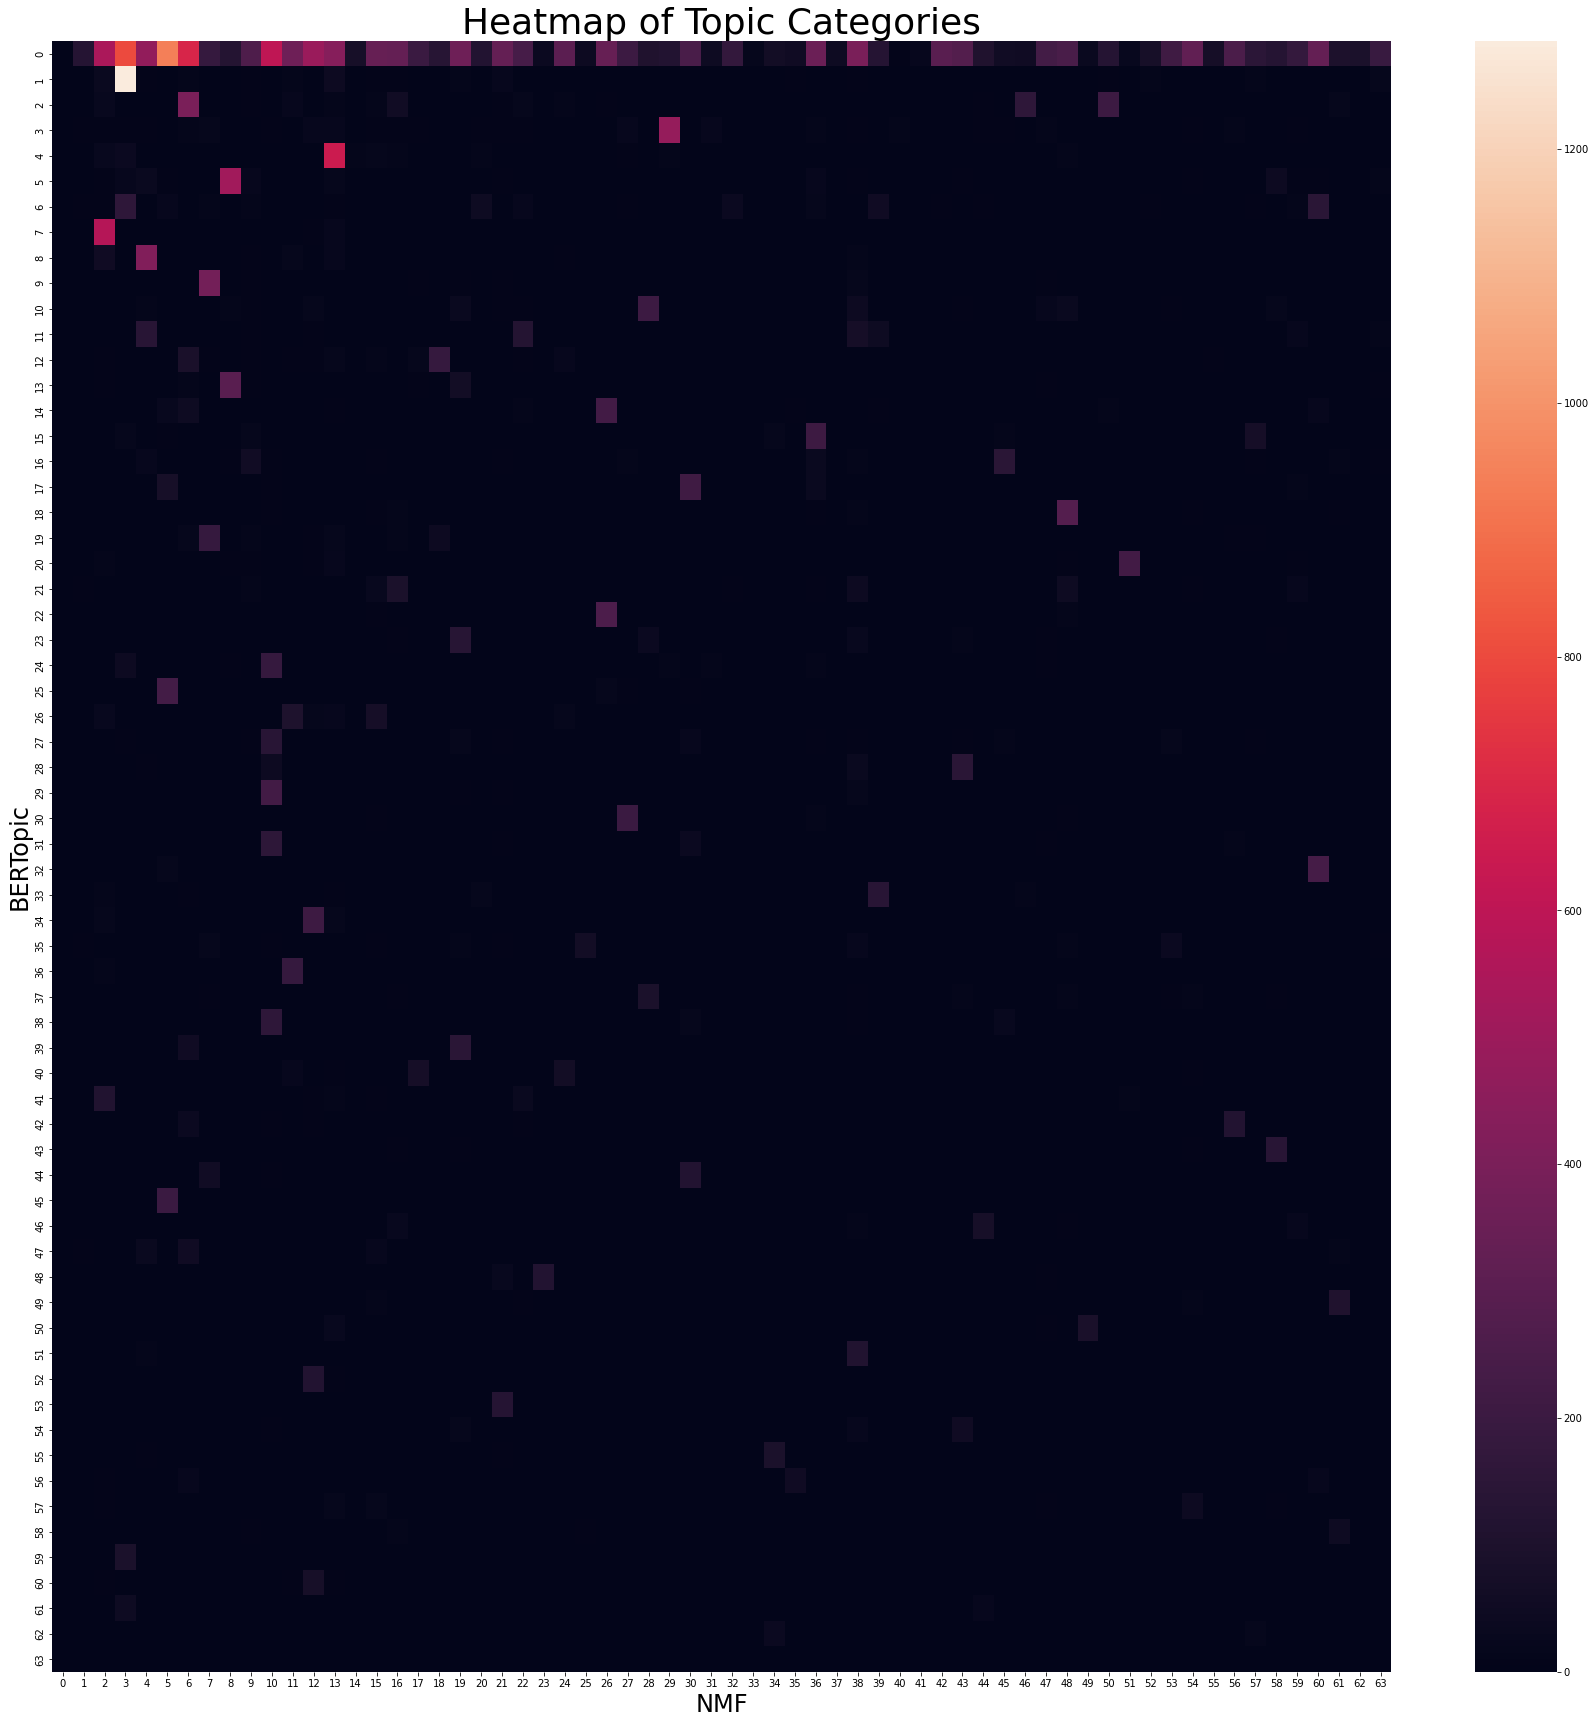

In [43]:
cm = confusion_matrix(df['bertopic'],df['nmf'])
plt.figure(figsize = (30,30))
sns.heatmap(cm)
plt.ylabel('BERTopic', fontsize=24)
plt.xlabel('NMF', fontsize=24)
plt.title('Heatmap of Topic Categories', fontsize=36)
plt.show()